In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
from scipy.interpolate import interp1d

In [3]:
mpk = np.genfromtxt(r'C:/Users/satvi/PhD_thesis/kk.dat')

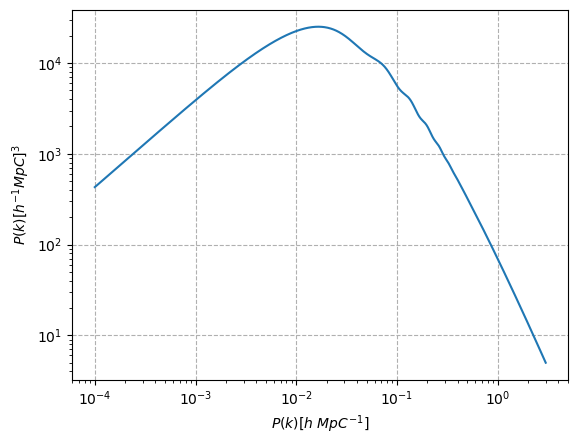

In [4]:
plt.plot(mpk[:,0],mpk[:,1])
plt.grid(linestyle = "dashed")
plt.ylabel('$P(k) [h^{-1}MpC]^3$')
plt.xlabel('$P(k) [h~MpC^{-1}]$')
plt.yscale('log')
plt.xscale('log')

In [6]:
interpolation_func = interp1d(mpk[:,0], mpk[:,1], kind='linear')

In [7]:
np.set_printoptions(linewidth=400)
np.set_printoptions(precision=4)
def distance1(length,cx,cy):
    l_by_2 = int(length/2)
    
    x_val = np.linspace(0,l_by_2*np.pi,l_by_2)+2*np.pi  #creating uniform x grid
    
    x_val_fft = np.concatenate([x_val[::-1],-x_val])
    
    xx, yy = np.meshgrid(x_val_fft, x_val_fft, indexing='ij')
    xx = np.roll(xx, shift = -l_by_2+cx, axis=0)
    yy = np.roll(yy, shift = -l_by_2+cy, axis=1)
    
    kxx = 2*np.pi/xx
    kyy = 2*np.pi/yy
    
    dist = np.zeros((length,length))
    for i in range(length):
        for j in range(length):
            dist[i,j] = np.sqrt((xx[i,j])**2 + (yy[i,j])**2)
    #dist = dist + 2*np.pi # to avoid division by zero
    return x_val_fft, kxx,kyy, dist



In [8]:
def pk_whitenoise(length):
    cx = int(length/2)
    cy=cx
    white_noise = np.random.normal(loc=0,scale=1,size=length**2).reshape(length,length)
    
    x_val_fft = distance1(length,cx,cy)[0]
    kxx = distance1(length,cx,cy)[1]
    kyy = distance1(length,cx,cy)[2]
    
    k_grid = np.zeros((length,length))
    
    for i in range(length):
        for j in range(length):
            k_grid[i,j] = np.sqrt(kxx[i,j]**2 + kyy[i,j]**2)
        
    del_k = interpolation_func(k_grid)    #Power spectra values for the k grid           

    white_noise_fft = np.fft.fft2(white_noise,norm='backward')
    
    #convolute in k space

    delta_k_conv = white_noise_fft * np.sqrt(del_k)
    delta_k_conv[0,0] = 0   #setting dc component to zero
    
    return delta_k_conv, k_grid

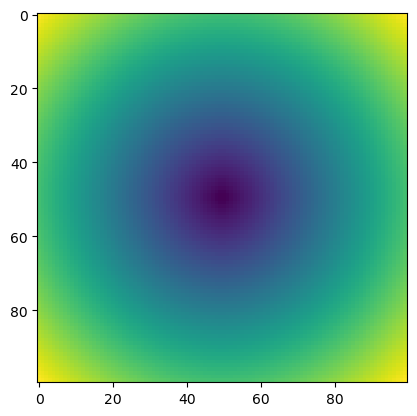

In [9]:
plt.imshow(distance1(100,50,50)[3])
# plt.savefig("example_distance.png")

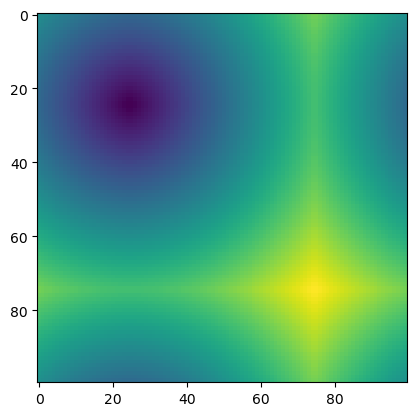

In [10]:
plt.imshow(distance1(100,25,25)[3])

In [11]:
length = 100
delta_k_conv = pk_whitenoise(length)[0]
delta_x_conv = np.fft.ifft2(delta_k_conv)
delta_x_trunc = delta_x_conv[1:,1:]    #length is 49 and not 50

In [ ]:
l_by_2 = int(length/2)
distmax = np.max(distance1(length,l_by_2,l_by_2)[3])
distmin = np.min(distance1(length,l_by_2,l_by_2)[3])

bins = int(distmax/distmin)

pk = np.zeros(bins)
pk_sample = np.zeros(bins)
for i in range(length-1):
    print(i)
    for j in range(length-1):   #due to truncation of zero row and column
        

        dist = distance1(length,i,j)[3]
        
        for m in range(length-1):
            for n in range(length-1):
                f = int(dist[m,n]/distmin)-1
                pk[f] = pk[f] + delta_x_trunc[m,n].real * delta_x_trunc[i,j].real
                pk_sample[f] = pk_sample[f] + 1

In [ ]:
xar = np.linspace(distmin*0.5,distmax-distmin/2,bins)
# xar = np.linspace(distmin,distmax-distmin/2,bins)
pk_avg = pk/pk_sample

test = np.fft.fft(pk_avg)


In [ ]:
mpk = np.genfromtxt(r'C:/Users/satvi/PhD_thesis/kk.dat')
plt.scatter(2*np.pi/xar[1:], np.abs(test[1:]),s=10)
plt.plot(mpk[:,0],mpk[:,1])
plt.grid(linestyle = "dashed")
plt.ylabel('$P(k) [h^{-1}MpC]^2$')
plt.xlabel('$k [h~MpC^{-1}]$')
plt.title("2d from correlation")
# plt.savefig("Pkz_0_2d_kxspace")
plt.xscale('log')
plt.yscale('log')
# plt.savefig("pkz_0correlation2d,")